## Importing libraries

In [1]:
import msgpack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

from collections import OrderedDict

from geexhp.pypsg import PSG
from geexhp.core import datamod, datavis, geostages
datavis.configure_matplotlib()

## Test 1 - Loading HWO configuration file for Modern Earth

In [2]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

In [3]:
molecules = config["ATMOSPHERE-LAYERS-MOLECULES"].split(',')
pressures = []
temperatures = []
concentration_dict = {mol: [] for mol in molecules}

for i in range(60):
    layer = config.get(f"ATMOSPHERE-LAYER-{i + 1}").split(',')
    pressure = float(layer[0])
    temperature = float(layer[1])
    concentrations = [float(value) for value in layer[2:]]
    
    pressures.append(pressure)
    temperatures.append(temperature)
    for j, mol in enumerate(molecules):
        concentration_dict[mol].append(concentrations[j])

data = {
    "Pressure": pressures,
    "Temperature": temperatures
}
data.update(concentration_dict)
mixing_ratio = pd.DataFrame(data)

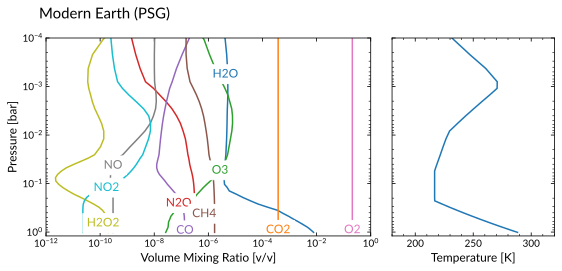

In [4]:
molecules = ["H2O", "CO2", "O3", "N2O", "CO", "CH4", "O2", "NO", "H2O2", "NO2"]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1.5]}, sharey=True)
for molecule in molecules:
    line, = ax[0].plot(mixing_ratio[molecule], mixing_ratio["Pressure"], label=molecule)
    if molecule in ["H2O2", "O3", "CO"]:
        x_pos = np.quantile(line.get_xdata(), q=0.75)
    else:
        x_pos = np.median(line.get_xdata())
    datavis.label_line(line, x=x_pos, label=molecule, align=False)
    
ax[0].invert_yaxis()
ax[0].axis([1e-12, 1, 1.2, 1e-4])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Volume Mixing Ratio [v/v]", ylabel="Pressure [bar]")

mixing_ratio.plot(x="Temperature", y="Pressure", ax=ax[1], legend=False)
ax[1].invert_yaxis()
ax[1].axis([180, 320, 1.2, 1e-4])
ax[1].set(xlabel="Temperature [K]", ylabel="")
ax[1].set_yscale("log")

fig.suptitle("Modern Earth (PSG)", x=0.08, y=0.95, horizontalalignment='left', 
                verticalalignment='top', fontsize=15)
plt.tight_layout();

In [3]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [4]:
config_HWC = config.copy()
geostages.modern_earth(config_HWC)
datamod.set_instrument(config_HWC, 'HWC')
result = psg.run(config_HWC)

In [6]:
print(result["header"])

# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Tue Aug 27 16:04:47 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Multiple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Exoplanet


- Some species, CH3Cl, do not have optimized correlated-k tables for the defined moderate resolutions, and will be analyzed at sub-par resolutions. In particular, there will be issues at the line cores. 

I had considered it the first time, but I dismissed it.

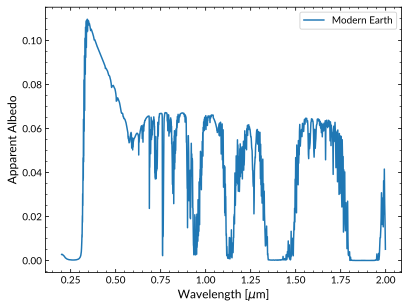

In [7]:
columns = ["WAVELENGTH", "ALBEDO"]
df_earth = pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)
datavis.plot_spectrum(df_earth, label="Modern Earth");

In [9]:
def test_instrument(config, instrument):
    datamod.set_instrument(config, instrument)
    result = psg.run(config)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)

In [23]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
dfs = [test_instrument(config.copy(), instrument) for instrument in instruments]
df = pd.concat(dfs).reset_index(drop=True)

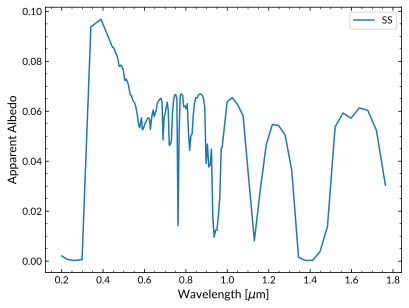

In [24]:
datavis.plot_spectrum(df, label="SS");

## Test 2 - Changing the abundances

In [12]:
def test_abundances(dictionary: dict, gas: str, multiplier: float) -> None:
    elements = ["CO2", "N2", "O2", "H2O", "CO", "C2H6", "HCN", "SO2", "O3", "CH4", "N2O", "NH3", "CH3Cl"]
    gas_index = elements.index(gas)
    for key, value in dictionary.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            gas_value = float(values[gas_index + 2])
            new_value = gas_value * multiplier       
            values[gas_index + 2] = str(new_value)
            dictionary[key] = ','.join(values)
    result = psg.run(dictionary)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:,[0,1]], columns=columns)

In [25]:
o2_modifications = [("O2", 2), ("O2", 0)]
df_double_O2, df_no_O2 = [test_abundances(config_HWC.copy(), gas, factor) for gas, factor in o2_modifications]

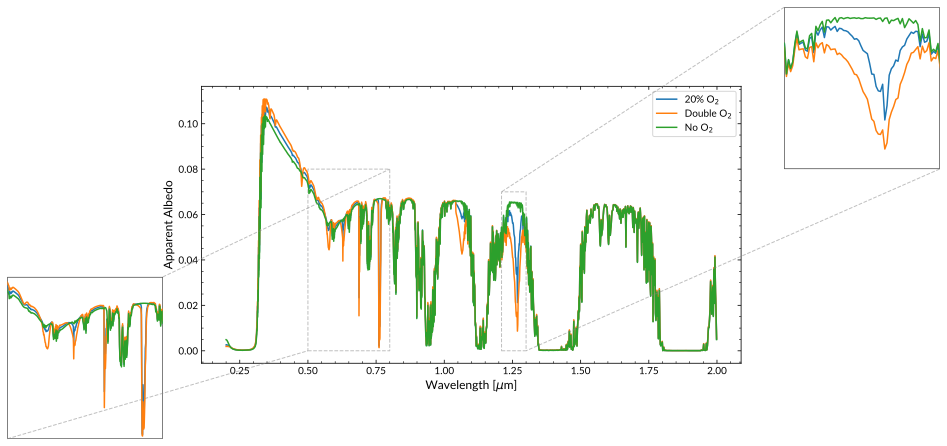

In [44]:
fig, ax_main = plt.subplots(figsize=(12, 5))

ax_main.plot(df_earth["WAVELENGTH"], df_earth["ALBEDO"], label="20% O${}_2$")
ax_main.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"], label="Double O${}_2$")
ax_main.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"], label="No O${}_2$")
ax_main.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo")
ax_main.legend()

fig.subplots_adjust(right=0.75)

ax_zoom1 = fig.add_axes([0.8, 0.65, 0.18, 0.45])
ax_zoom1.plot(df_earth["WAVELENGTH"], df_earth["ALBEDO"])
ax_zoom1.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"])
ax_zoom1.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"])
ax_zoom1.set_xlim(1.21, 1.3)
ax_zoom1.set_ylim(0.0, 0.07)
ax_zoom1.axis('off')
rect1 = Rectangle((0, 0), 1, 1, transform=ax_zoom1.transAxes, linewidth=1, edgecolor='black', facecolor='none')
ax_zoom1.add_patch(rect1)

ax_zoom2 = fig.add_axes([-0.1, -0.1, 0.18, 0.45])
ax_zoom2.plot(df_earth["WAVELENGTH"], df_earth["ALBEDO"])
ax_zoom2.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"])
ax_zoom2.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"])
ax_zoom2.set_xlim(0.5, 0.8)
ax_zoom2.set_ylim(0, 0.08)
ax_zoom2.axis('off')
rect2 = Rectangle((0, 0), 1, 1, transform=ax_zoom2.transAxes, linewidth=1, edgecolor='black', facecolor='none')
ax_zoom2.add_patch(rect2)

mark_inset(ax_main, ax_zoom1, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--', alpha=0.5)
mark_inset(ax_main, ax_zoom2, loc1=1, loc2=3, fc="none", ec="0.5", linestyle='--', alpha=0.5);

## Test 3 - Modifying atmospheric pressure (mbar)

In [17]:
def test_pressure(config, pressure):
    config["ATMOSPHERE-PRESSURE"] = str(pressure)
    result = psg.run(config)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

In [18]:
# 500 mbar = .5 bar
# The spectrum returned nothing for double and 4x the atmospheric pressure
pressures = [500, 1000, 1500]
df_half_atm, df_1_0_atm, df_1_5_atm = [test_pressure(config_HWC.copy(), pressure) for pressure in pressures]

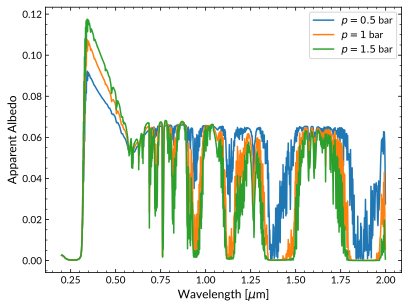

In [19]:
_, ax = plt.subplots()
datavis.plot_spectrum(df_half_atm, label="$p = 0.5$ bar", ax=ax)
datavis.plot_spectrum(df_1_0_atm, label="$p = 1$ bar", ax=ax)
datavis.plot_spectrum(df_1_5_atm, label="$p = 1.5$ bar", ax=ax);

When atmospheric pressure decreases, it generally indicates a more rarefied atmosphere. On the other hand, higher atmospheric pressure suggests a denser and more expansive atmosphere. The correlation between atmospheric density and the visibility of spectral signatures is intrinsically linked to photon-molecule interaction. In a dense atmosphere, the molecules present have more opportunities to interact with photons, resulting in more pronounced spectral signatures. However, when the atmosphere is more rarefied, these interactions decrease, leading to significant attenuation of spectral signatures.

## Test 4 - Diferents stars

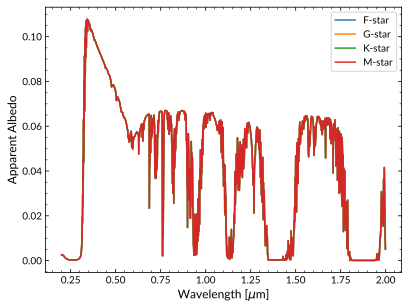

In [57]:
# This is interesting, if you run it here you will notice that the difference is minimal from one spectrum to another.
def test_typestars(config, class_star):
    config['OBJECT-STAR-TYPE'] = class_star
    config['GEOMETRY-STELLAR-TYPE'] = class_star

    params = {
        'F': {'temp_range': (6000, 7220), 'radius_range': (1.18, 1.79), 'mag_range': (2.50, 4.22)},
        'G': {'temp_range': (5340, 5920), 'radius_range': (0.876, 1.12), 'mag_range': (4.40, 5.34)},
        'K': {'temp_range': (3940, 5280), 'radius_range': (0.552, 0.817), 'mag_range': (5.54, 7.59)},
        'M': {'temp_range': (2320, 3870), 'radius_range': (0.104, 0.559), 'mag_range': (7.75,  13.62)}
    }

    star_temperature = round(np.random.uniform(*params[class_star]['temp_range']), 3)
    star_radius = round(np.random.uniform(*params[class_star]['radius_range']), 3)
    star_mag = round(np.random.uniform(*params[class_star]['mag_range']), 3)

    config['OBJECT-STAR-RADIUS'] = star_radius
    config['OBJECT-STAR-TEMPERATURE'] = star_temperature
    config['GEOMETRY-STELLAR-TEMPERATURE'] = star_temperature
    config["GEOMETRY-STELLAR-MAGNITUDE"] = star_mag
    
    result = psg.run(config)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

star_types = ["F", "G", "K", "M"]
labels = ["F-star", "G-star", "K-star", "M-star"]
dataframes = [test_typestars(config_HWC.copy(), star_type) for star_type in star_types]

_, ax = plt.subplots()

for df, label in zip(dataframes, labels):
    datavis.plot_spectrum(df, label=label, ax=ax)

plt.show()

## Generate a random model

In [64]:
random_config = config_HWC.copy()
datamod.random_planet(random_config, geostages.molweight_modern())
result_random = psg.run(random_config)

columns = ["WAVELENGTH", "ALBEDO"]
df_rnd = pd.DataFrame(result_random["spectrum"][:, [0,1]], columns=columns)

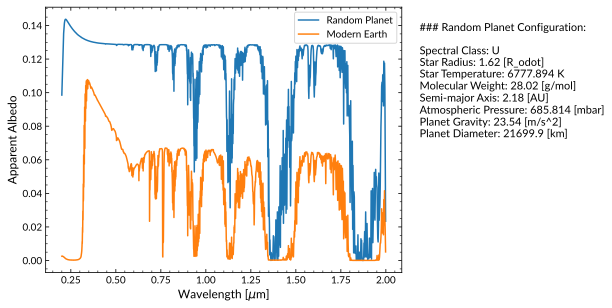

In [65]:
SPECTRAL_CLASS = random_config['OBJECT-STAR-TYPE']
STAR_RADIUS = random_config['OBJECT-STAR-RADIUS']
STAR_TEMPERATURE = random_config['OBJECT-STAR-TEMPERATURE']
MOLECULAR_WEIGHT = round(random_config['ATMOSPHERE-WEIGHT'], 2)
SEMI_MAJOR_AXIS = round(random_config['OBJECT-STAR-DISTANCE'], 2)
ATMOSPHERIC_PRESSURE = random_config["ATMOSPHERE-PRESSURE"]
PLANET_GRAVITY = round(random_config['OBJECT-GRAVITY'], 2)
PLANET_DIAMETER = round(random_config['OBJECT-DIAMETER'], 2)

_, ax = plt.subplots()
datavis.plot_spectrum(df_rnd, label="Random Planet", ax = ax)
datavis.plot_spectrum(df_earth, label="Modern Earth", ax = ax)

text = ("### Random Planet Configuration:\n\n"
        f"Spectral Class: {SPECTRAL_CLASS}\n"
        f"Star Radius: {STAR_RADIUS} [R_odot]\n"
        f"Star Temperature: {STAR_TEMPERATURE} K\n"
        f"Molecular Weight: {MOLECULAR_WEIGHT} [g/mol]\n"
        f"Semi-major Axis: {SEMI_MAJOR_AXIS} [AU]\n"
        f"Atmospheric Pressure: {ATMOSPHERIC_PRESSURE} [mbar]\n"
        f"Planet Gravity: {PLANET_GRAVITY} [m/s^2]\n"       
        f"Planet Diameter: {PLANET_DIAMETER} [km]\n"
        )

plt.text(1.05, 0.7, text,
        horizontalalignment='left',
        verticalalignment='center',
        fontsize = 11, transform=plt.gca().transAxes);

## Great Oxidation Event

In [5]:
def justdoit(config, event, instrument):
    config_copy = config.copy()
    event(config_copy)
    datamod.set_instrument(config_copy, instrument)
    result = psg.run(config_copy)
    columns = ["WAVELENGTH", "ALBEDO"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

In [6]:
goe_data = justdoit(config, geostages.after_goe, "HWC")
modern = justdoit(config, geostages.modern_earth, "HWC")

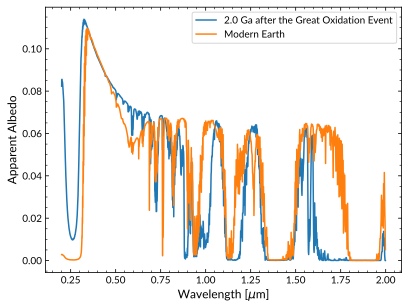

In [7]:
_, ax = plt.subplots()
datavis.plot_spectrum(goe_data, label="2.0 Ga after the Great Oxidation Event", ax=ax)
datavis.plot_spectrum(modern, label="Modern Earth", ax=ax);